#Adversarial Image Generation using CIFAR-10

##Modules and Utilities

In [0]:
'''
DCGAN using Keras
Author: Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments
Dependencies: tensorflow 1.0 and keras 2.0
Usage: python3 dcgan_mnist.py
'''

import numpy as np
import time
from keras.datasets import cifar10
from keras.datasets import cifar100

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )
        

##GAN

In [0]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.5
        alpha = 0.005
        
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

    
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.7
        depth = 64+64+64+64
        dim = 8
        momentum = 0.75
        
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(3, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM
      

##CFAR-10 GAN

In [0]:
class CFAR_DCGAN(object):
    def __init__(self, one_class=None):
        self.img_rows = 32
        self.img_cols = 32
        self.channel = 3

        (x_train, y_train), (x_test, y_test) = cifar10.load_data()


        if one_class is not None:
          self.x_train = []
          for i in range(len(x_train)):
            if y_train[i] == one_class:
              self.x_train.append(x_train[i])
          self.x_train = np.array(self.x_train) / 255
        
        else:
          self.x_train = x_train / 255
          
        self.DCGAN = DCGAN(self.img_rows, self.img_cols, self.channel) 
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()
        
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            
            
            images_fake = self.generator.predict(noise)
              
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=10, noise=None, step=0):
        filename = 'cfar.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols, self.channel])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
            

##Execution

###Airplane

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=0)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

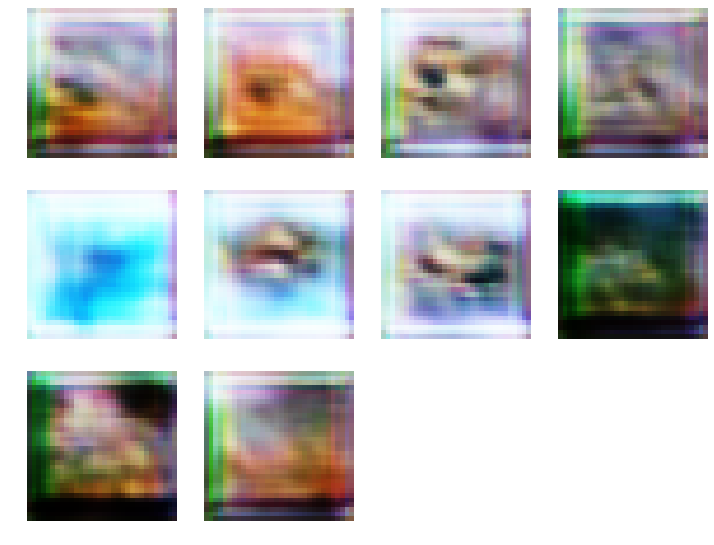

In [0]:
cfar_dcgan.plot_images(fake=True)

###Automobile

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=1)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

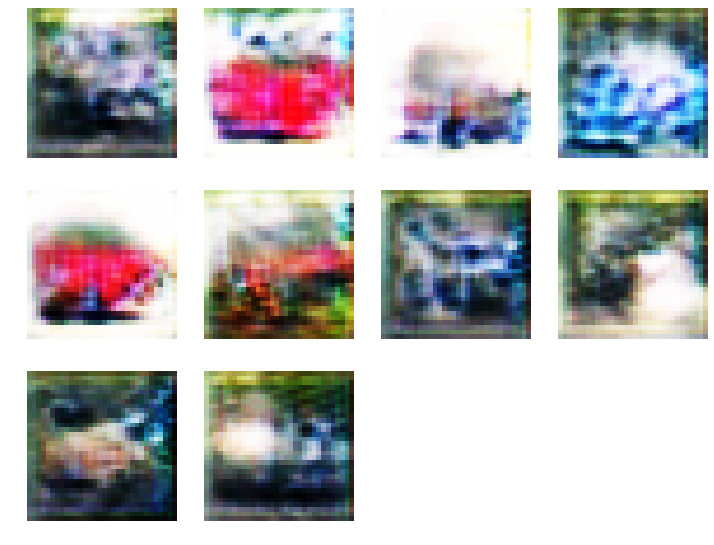

In [0]:
cfar_dcgan.plot_images(fake=True)

###Bird

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=2)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

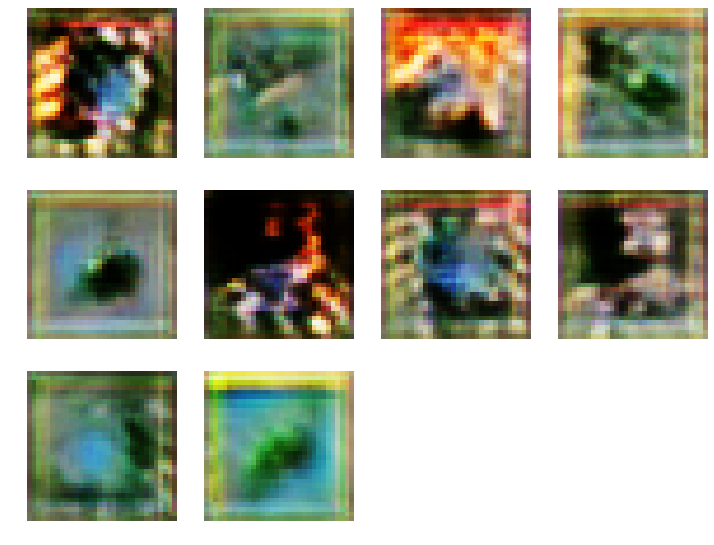

In [0]:
cfar_dcgan.plot_images(fake=True)

###Cat

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=3)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

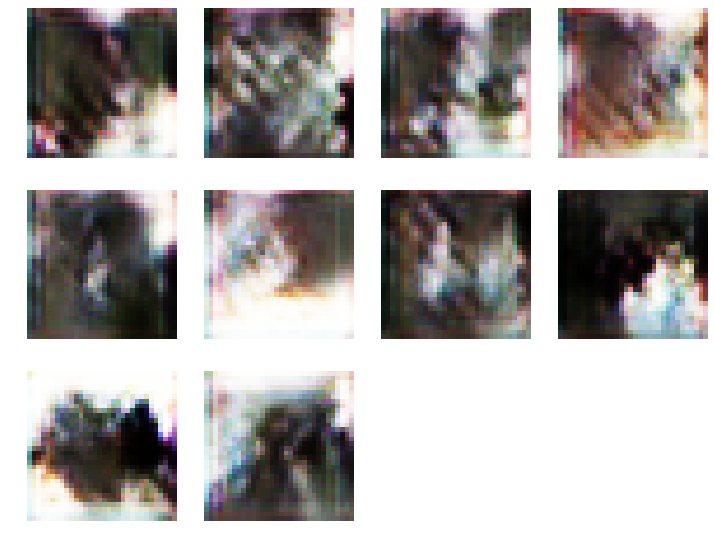

In [0]:
cfar_dcgan.plot_images(fake=True)

###Deer

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=4)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

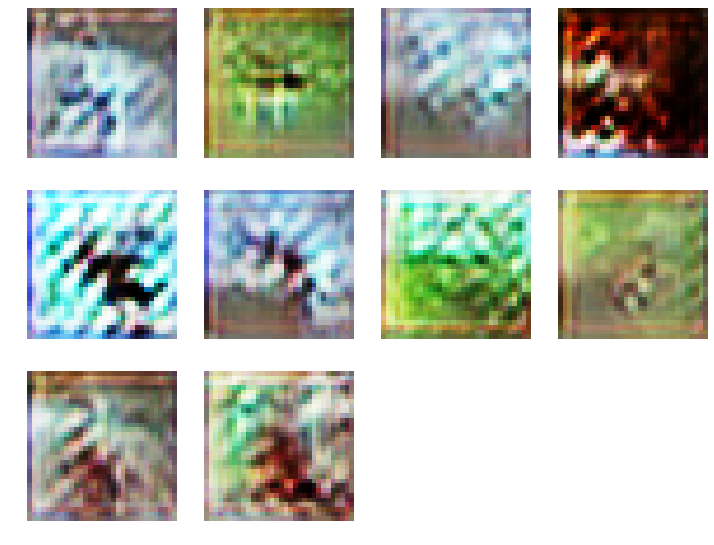

In [0]:
cfar_dcgan.plot_images(fake=True)

###Dog

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=5)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

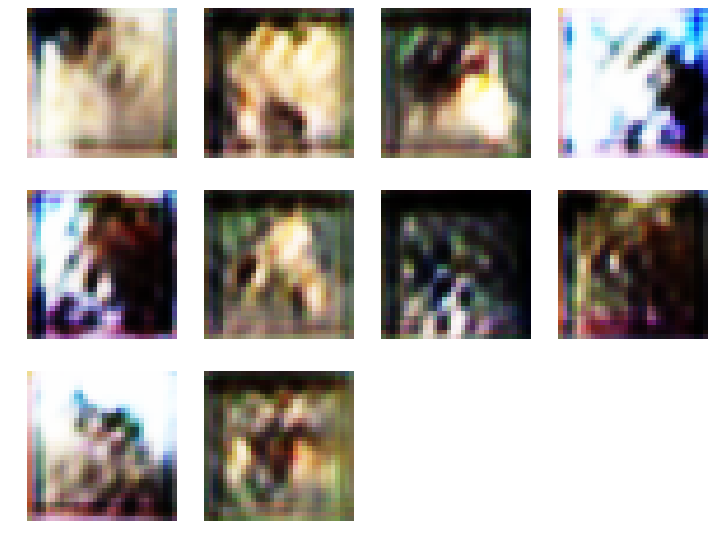

In [0]:
cfar_dcgan.plot_images(fake=True)

###Frog

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=6)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

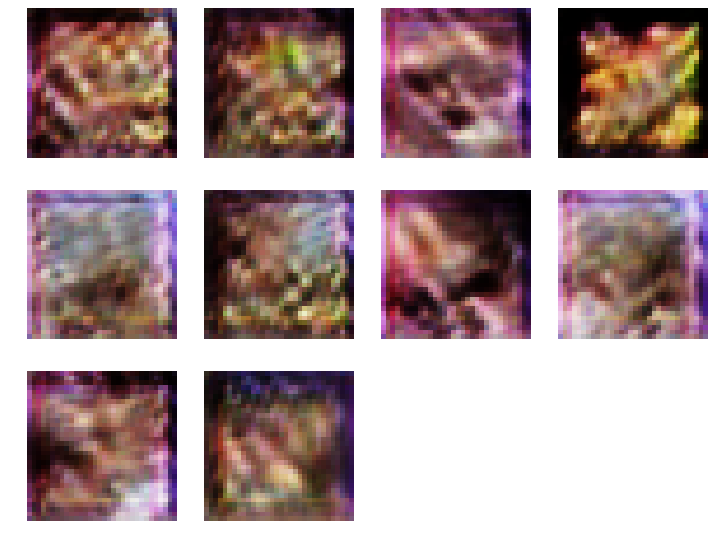

In [0]:
cfar_dcgan.plot_images(fake=True)

###Horse

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=7)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

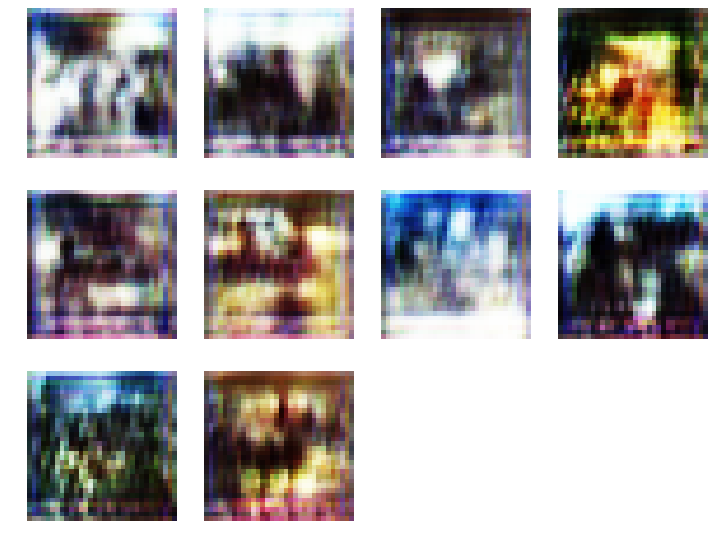

In [0]:
cfar_dcgan.plot_images(fake=True)

###Ship

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=8)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

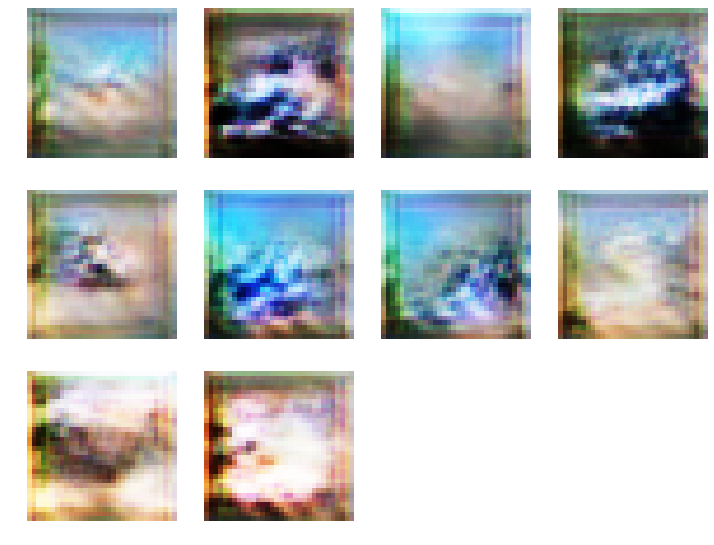

In [0]:
cfar_dcgan.plot_images(fake=True)

###Truck

In [0]:
cfar_dcgan = CFAR_DCGAN(one_class=9)
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

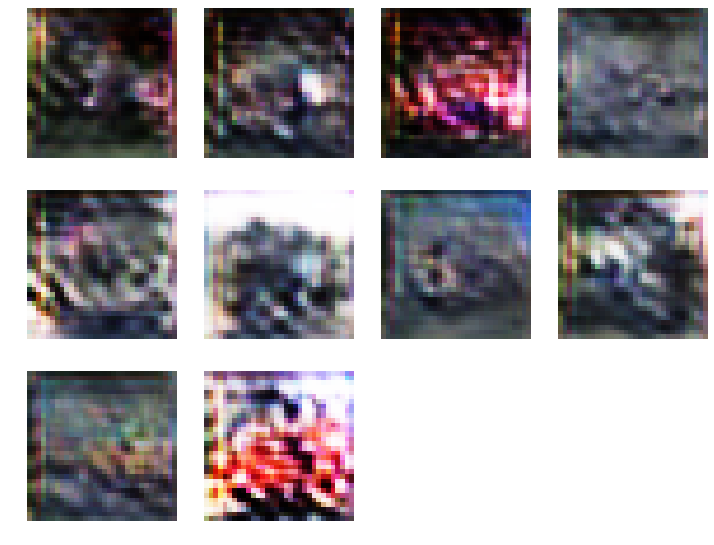

In [0]:
cfar_dcgan.plot_images(fake=True)

###Full-Set

In [0]:
cfar_dcgan = CFAR_DCGAN()
timer = ElapsedTimer()
cfar_dcgan.train(train_steps=10000, batch_size=128, save_interval=500)
timer.elapsed_time()

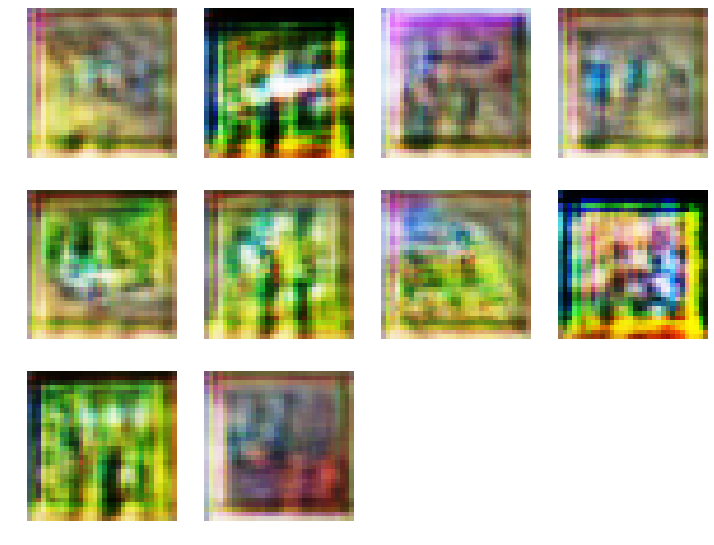

In [0]:
cfar_dcgan.plot_images(fake=True)